$$
\frac{\partial P_i}{\partial t} = \mu_{ref} \cdot T_f \cdot \left(1- exp\left(\frac{-\alpha_i^{Chl}\ \theta_i^C\ I}{\mu_{ref}\ T_f\ V_i}\right)\right) \cdot V_i \cdot P_i - g_z^{\max} \cdot Z \cdot \frac{P_i}{K_{P_i} + P_i} - m_i \cdot T_f \cdot P_i - \alpha_i \cdot P_i^{1.75}  $$

$\mu_{ref} = 5.0 d^{-1}$                                   Maximum C-spec growth rate at $T_{ref}$ for small phytoplankton and diatoms  
$T_{ref} = 30 ^\circ C$                                    Refrence temperature  
$\theta_{max,sp}^N = 2.5\ mg Chl/mmol$                     Maximum $\theta^N (Chl/N)$ for small phytoplankton  
$\theta_{max,diat}^N = 4.0\ mg Chl/mmol$                   Maximum $\theta^N (Chl/N)$ for diatoms  
$\alpha_{sp}^{Chl} = 0.39\ mmol\ m^2/(mg\ Chl\ W\ day)$    Chl-spec initial slope of P_I curve for small phytoplankton
$\alpha_{diat}^{Chl} = 0.28\ mmol\ m^2/(mg\ Chl\ W\ day)$  Chl-spec initial slope of P_I curve for diatoms  
$K_{sp}^{Dfe} = 3.0e-05\ mmol/m^3$                         Fe uptake half-sat constant for small phytoplankton  
$K_{diat}^{Dfe} = 7.0e-05\ mmol/m^3$                       Fe uptake half-sat constant for diatoms  
$K_{sp}^{NO^3} = 0.25\ mmol/m^3$                           $NO^3$ uptake half-sat constant for small phytoplankton

The maximum C-spec growth rate at \( T_{ref} \) for small phytoplankton and diatoms is given by:

$\mu_{ref} = 5.0\; d^{-1}$  

The reference temperature is given by \( T_{ref} = 30^\circ\; \mathrm{C} \).

For small phytoplankton:

$\theta_{max,sp}^N = 2.5\; mg\; Chl/mmol$  

For diatoms:

$\theta_{max,diat}^N = 4.0\; mg\; Chl/mmol$  

The Chl-spec initial slope of the P-I curve for small phytoplankton is:

$\alpha_{sp}^{Chl} = 0.39\; \mathrm{mmol}\; m^{-2}\; (mg\; Chl\; W\; day)^{-1}$  

And for diatoms:

$\alpha_{diat}^{Chl} = 0.28\; \mathrm{mmol}\; m^{-2}\; (mg\; Chl\; W\; day)^{-1}$

In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint_adjoint as odeint
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
# Neuromancer imports (symbolic API)
import neuromancer as nm
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.trainer import Trainer
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable

In [4]:
ds = xr.open_dataset("regridded_data/2015-2021_combined.nc")

In [5]:
mu_ref = 5.0
k_dfe = 3 ** (-0.5)
k_no3 = 0.5
k_po4 = 0.01
ds['V_dfe'] = ds['dfe'] / (k_dfe + ds['dfe'])
ds['V_no3'] = ds['no3'] / (k_no3 + ds['no3'])
ds['V_po4'] = ds['po4'] / (k_po4 + ds['po4'])
ds['Tf'] = 1.7 ** np.exp((ds['sst'] - 30) / 10)

# Convert to NumPy arrays, compute the minimum, and then convert back to xarray
V_no3_array = ds['V_no3'].values  # Convert to NumPy array
V_po4_array = ds['V_po4'].values  # Convert to NumPy array
V_dfe_array = ds['V_dfe'].values   # Assuming V_dfe is already defined

# Calculate the minimum using NumPy
V_min = np.minimum(np.minimum(V_dfe_array, V_po4_array), V_no3_array)

# Assign the result back to the DataArray in the xarray Dataset
ds['V'] = xr.DataArray(V_min, dims=ds['V_dfe'].dims, coords=ds['V_dfe'].coords)

df = ds.to_dataframe()
df = df.dropna(how='any')
scaler = MinMaxScaler(feature_range=(0,10))
scaled_array = scaler.fit_transform(df)
norm_df = pd.DataFrame(scaled_array, index=df.index, columns=df.columns)
print(norm_df.head())
print(norm_df.info())


                              dfe       no3       po4       sil       rsn  \
lon    lat   month_year                                                     
-179.5 -76.5 2015-01-01  0.042463  2.457866  5.414602  2.663714  6.223525   
             2015-02-01  0.056386  2.517316  5.486631  2.416398  3.783490   
             2015-12-01  0.048093  2.668628  5.709538  3.263838  8.403666   
             2016-01-01  0.033411  2.665089  5.803986  3.021275  5.299753   
             2016-02-01  0.066006  2.360248  5.209874  2.289098  3.853204   

                              mld       ssh       sal       sst      chla  \
lon    lat   month_year                                                     
-179.5 -76.5 2015-01-01  0.031551  1.773168  7.995484  0.429358  0.053512   
             2015-02-01  0.096969  1.718363  8.200290  0.225703  0.076863   
             2015-12-01  0.076738  1.647681  8.305805  0.355078  0.401371   
             2016-01-01  0.089604  1.587883  8.291054  0.466634  0.112831  

In [6]:
# Resetting the index to work with columns directly
df = norm_df.sort_index().reset_index()
df['month_year'] = pd.to_datetime(df['month_year'])
start_date = df['month_year'].min()
# df['months_from_start'] = (df['month_year'] - df['month_year'].min()) // pd.Timedelta('30D')
df['months_from_start'] = ((df['month_year'].dt.year - start_date.year) * 12 + 
                                  (df['month_year'].dt.month - start_date.month))
# Count months per (lon, lat)
month_counts = df.groupby(['lon', 'lat'])['months_from_start'].nunique()
expected_months = df['months_from_start'].nunique()
valid_locations = month_counts[month_counts == expected_months].index

# Filter the DataFrame
df_filtered = df.set_index(['lon', 'lat']).loc[valid_locations].reset_index()
df_filtered = df_filtered.sort_values(['lon', 'lat', 'months_from_start'])
print(df_filtered.shape)
df_sampled = df_filtered.sample(n=1000, random_state=42).sort_values(['lon', 'lat', 'months_from_start'])
print(df_sampled.shape)

(66744, 26)
(1000, 26)


In [7]:
# Define input and target columns
input_cols = ['rsn', 'Tf', 'V', 'logchla']
target_col = ['logmcro']

# Group by location
grouped = df_sampled.groupby(['lon', 'lat'])

X_list, Y_list = [], []
for _, group in grouped:
    group = group.sort_values('months_from_start')
    X = group[input_cols].values
    Y = group[target_col].values
    X_list.append(torch.tensor(X, dtype=torch.float32))
    Y_list.append(torch.tensor(Y, dtype=torch.float32))

In [8]:
# needed only if the sequences are of different lengths
nsteps = max(len(x) for x in X_list)
X_padded = torch.stack([torch.nn.functional.pad(x, (0, 0, 0, nsteps - x.shape[0])) for x in X_list])
Y_padded = torch.stack([torch.nn.functional.pad(y, (0, 0, 0, nsteps - y.shape[0])) for y in Y_list])

X_padded = X_padded.view(len(X_list), nsteps, -1)  # shape: (nbatch, nsteps, n_features)
Y_padded = Y_padded.view(len(Y_list), nsteps, -1)  # shape: (nbatch, nsteps, 1)

In [9]:
# Set split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Compute split indices
nbatch = len(X_list)
n_train = int(train_ratio * nbatch)
n_val = int(val_ratio * nbatch)
n_test = nbatch - n_train - n_val

# Shuffle indices for reproducibility
torch.manual_seed(42)
indices = torch.randperm(nbatch)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

X_train = X_padded[train_idx]
Y_train = Y_padded[train_idx]

X_val = X_padded[val_idx]
Y_val = Y_padded[val_idx]

X_test = X_padded[test_idx]
Y_test = Y_padded[test_idx]

train_data = DictDataset({
    'Y0':Y_train[:, 0, :],   # initial Pi (shape: [B, 1])
    'X': X_train,            # external inputs (shape: [B, T, 4])
    'Y': Y_train             # ground truth Pi sequence
}, name='train')

val_data = DictDataset({
    'Y0': Y_val[:, 0, :],
    'X': X_val,
    'Y': Y_val
}, name='val')

test_data = DictDataset({
    'Y0': Y_test[:, 0, :],
    'X': X_test,
    'Y': Y_test
}, name='test')

train_loader = DataLoader(train_data, batch_size=32, collate_fn=train_data.collate_fn, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, collate_fn=val_data.collate_fn, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=test_data.collate_fn, shuffle=False)

In [10]:
from neuromancer import blocks

# define UDE system in Neuromancer
class PlanktonHybrid(ode.ODESystem):
    def __init__(self, block, insize=5, outsize=1):
        """
        :param block: Neural block (e.g. MLP) that learns unknown dynamics
        :param insize: Number of input features (rsn, Tf, V, logchla)
        :param outsize: Number of output features (logmcro)
        """
        super().__init__(insize=insize, outsize=outsize)
        self.block = block
        
        # Mechanistic parameters
        self.mu_ref = torch.tensor(5.0)
        self.alpha_chl =torch.tensor(0.28)
        self.m_i = nn.Parameter(torch.tensor(0.05), requires_grad=True)
        self.alpha_i = nn.Parameter(torch.tensor(0.01), requires_grad=True)
        assert self.block.in_features == 5
        assert self.block.out_features == 2
        
    def ode_equations(self, Pi, U):
        """
        Pi: shape (B, 1) — current plankton biomass
        U: shape (B, 4) — external inputs [I, Tf, V, logchla]
        """
        # Concatenate inputs and state
        xu = torch.cat([U, Pi], dim=-1)  # shape: (B, 5)

        # Neural block outputs
        learned_theta, learned_graz = torch.split(self.block(xu), 1, dim=-1)
        # ensure positive grazing via softplus (or relu)
        learned_graz = F.softplus(learned_graz_raw)

        # Extract environmental drivers
        I  = U[:, [0]]
        Tf = U[:, [1]]
        V  = U[:, [2]]
        logchla = U[:, [3]]    

        # Mechanistic dynamics
        denom = torch.clamp(self.mu_ref * Tf * V, min=1e-6)
        exponent = torch.clamp(-self.alpha_chl * learned_theta * I / denom, min=-50.0, max=50.0)
        growth = self.mu_ref * Tf * (1 - torch.exp(exponent)) * V * Pi
        mortality = self.m_i * Tf * Pi
        aggregation = self.alpha_i * (Pi ** 1.75)

        # Final dynamics
        dPi = growth - learned_graz - mortality - aggregation
        
        # final safety clamp
        dPi = torch.nan_to_num(dPi, nan=0.0, posinf=1e6, neginf=-1e6)
        return dPi

# Define a neural block with 5 inputs and 2 outputs
neural_block = blocks.MLP(
    insize=5,
    outsize=2,
    hsizes=[64, 64],             # two hidden layers
    nonlin=torch.nn.ReLU,        # activation function
    bias=True,
    linear_map=torch.nn.Linear
)

# Non-autonomous
class PlanktonNode(Node):
    def forward(self, Y0, X):
        """
        Y0: initial state, shape (B, state_dim)
        X: sequence of inputs, shape (B, T, input_dim)
        returns: Y_pred of shape (B, T, state_dim)
        """
        B, T, _ = X.shape
        Pi = Y0
        Y_pred_seq = []

        for t in range(T):
            U_t = X[:, t, :]       # shape (B, input_dim)
            Pi = fxRK4(Pi, U_t)   # RK4 step: Pi (B, state_dim), U_t (B, input_dim)
            Y_pred_seq.append(Pi)

        Y_pred = torch.stack(Y_pred_seq, dim=1)  # (B, T, state_dim)
        return Y_pred


In [13]:
# Instantiate your hybrid system
fx = PlanktonHybrid(block=neural_block)

ts = 1.0  # time step size (e.g. 1 month)
# integrate UDE model
fxRK4 = integrators.RK4(fx, h=ts)

# create symbolic UDE model
plankton_node = Node(
    callable=fxRK4,
    input_keys=['Y0', 'X'],      # Y0 = initial Pi, X = external inputs
    output_keys=['Y_pred'],     # predicted output sequence
    name='PlanktonUDE'
)
dynamics_model = System(
    nodes=[plankton_node],
    nsteps=nsteps             # e.g. 72 months
)

# define symbolic losses
Y = variable('Y')             # true sequence
Y_pred = variable('Y_pred')   # predicted sequence

# trajectory tracking loss
tracking_loss = 1.0 * ((Y_pred == Y)^2)
tracking_loss.name = 'tracking_loss'

# One-step loss
onestep_loss = 1.0 * ((Y_pred[:, 1, :] == Y[:, 1, :])^2)
onestep_loss.name = 'onestep_loss'

# Finite difference loss
Y_fd = Y[:, 1:, :] - Y[:, :-1, :]
Y_pred_fd = Y_pred[:, 1:, :] - Y_pred[:, :-1, :]
fd_loss = 2.0 * ((Y_fd == Y_pred_fd)^2)
fd_loss.name = 'FD_loss'

# Initial condition consistency
init_loss = (Y_pred[:, 0, :] == Y[:, 0, :])^2
init_loss.name = 'init_loss'

# # parameter regularisation loss
# alpha_i = variable('PlanktonUDE.alpha_i')
# m_i = variable('PlanktonUDE.m_i')
# reg_loss = 0.01 * (alpha_i ** 2 + m_i ** 2)
# reg_loss.name = 'symbolic_reg'

# add weights
tracking_loss.weight = 1.0
onestep_loss.weight = 1.0
fd_loss.weight = 2.0
init_loss.weight = 0.5
# reg_loss.weight = 0.01

# aggregate list of objective terms and constraints
objectives = [tracking_loss, onestep_loss, fd_loss, init_loss]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(
    [dynamics_model], 
    loss,
    grad_inference=True     # enables symbolic gradient flow
)

In [14]:
import csv, os

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# device = 'cuda' if torch.cuda.is_available() elif device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
problem.to(device)
optimizer = torch.optim.Adam(problem.parameters(), lr=0.003)

trainer = Trainer(
    problem,
    train_loader,
    val_loader,
    test_data,
    optimizer,
    patience=5,
    warmup=5,
    epochs=10,
    eval_metric="val_loss",
    train_metric="train_loss",
    dev_metric="val_loss",
    test_metric="val_loss",
)

cuda


In [15]:
best_model = trainer.train()
problem.load_state_dict(best_model)

AssertionError: 

In [7]:
# --------------------------------------------------------------------
# Model setup
# --------------------------------------------------------------------
fx = HybridRHS(n_inputs=3, n_hidden=64, n_outputs=1).to(device)
fxRK4 = integrators.RK4(fx, h=0.1)
ude = Node(fxRK4, ['xn', 'un'], ['xn'], name='UDE')
dynamics_model = System([ude], nsteps=max_len - 1).to(device)

optimizer = torch.optim.Adam(fx.parameters(), lr=1e-6)
# # weight decay for only neural network parameters
# param_groups = [
#     {"params": [p for n, p in fx.named_parameters() if "theta" not in n and "m" not in n and "alpha" not in n], "weight_decay": 1e-4},
#     {"params": [p for n, p in fx.named_parameters() if any(k in n for k in ["theta", "m", "alpha"])], "weight_decay": 0.0},
# ]
# optimizer = torch.optim.AdamW(param_groups, lr=1e-5)
# Optional LR scheduler (ReduceLROnPlateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7
)

# --------------------------------------------------------------------
# Utility functions
# --------------------------------------------------------------------
def has_nan_inf(x):
    return torch.isnan(x).any() or torch.isinf(x).any()

def get_param(name):
    """Safely extract scalar param if exists"""
    p = dict(fx.named_parameters()).get(name, None)
    return p.item() if p is not None else np.nan

# --------------------------------------------------------------------
# Paths
# --------------------------------------------------------------------
log_dir = "checkpoints"
os.makedirs(log_dir, exist_ok=True)
log_path = os.path.join(log_dir, "training_log.csv")
best_model_path = os.path.join(log_dir, "best_model.pt")

cuda


In [8]:
def train_model(
    fx,
    n_epochs = 30,
    patience=5, 
    log_params=['m','alpha'],
    train_loader=None,
    val_loader=None,
    optimizer=None,
    scheduler=None,
    log_dir=None,
    log_path=None,
    best_model_path=None,
    device='cpu',
    restart = False
    ):
    print(device)
    # --------------------------------------------------------------------
    # 🧩 SAFE RESTART + BACKUP LOGIC
    # --------------------------------------------------------------------
    if restart:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_dir = os.path.join(log_dir, f"backup_{timestamp}")
        os.makedirs(backup_dir, exist_ok=True)

        for f in [best_model_path, log_path]:
            if f is not None and os.path.exists(f):
                shutil.move(f, os.path.join(backup_dir, os.path.basename(f)))
                print(f"🧩 Moved previous file to backup: {f}")
        print(f"🗂️  Backup created at: {backup_dir}")

        start_epoch = 0
        best_val_loss = float('inf')
    else:
        start_epoch = 0
        best_val_loss = float('inf')

        if os.path.exists(best_model_path):
            checkpoint = torch.load(best_model_path, map_location=device, weights_only=True)
            fx.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            if 'scheduler_state_dict' in checkpoint:
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            best_val_loss = checkpoint.get('val_loss', float('inf'))
            start_epoch = checkpoint.get('epoch', 0)
            print(f"🔄 Resuming from epoch {start_epoch}, best_val_loss={best_val_loss:.6f}")
    
    # # --------------------------
    # # Resume Logic
    # # --------------------------
    # # Set restart to True to delete previous training and start fresh and to False to resume from checkpoint
    # if restart:
    #     if os.path.exists(best_model_path):
    #         os.remove(best_model_path)
    #         print("🧹 Removed previous checkpoint.")
    #     if os.path.exists(log_path):
    #         os.remove(log_path)
    #         print("🧹 Removed previous training log.")
    #     start_epoch = 0
    #     best_val_loss = float('inf')
    # else:
    #     start_epoch = 0
    #     best_val_loss = float('inf')
    #     if os.path.exists(best_model_path):
    #         checkpoint = torch.load(best_model_path, map_location=device)
    #         fx.load_state_dict(checkpoint['model_state_dict'])
    #         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #         if 'scheduler_state_dict' in checkpoint:
    #             scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    #         best_val_loss = checkpoint.get('val_loss', float('inf'))
    #         start_epoch = checkpoint.get('epoch', 0)
    #         print(f"🔄 Resuming from epoch {start_epoch}, best_val_loss={best_val_loss:.6f}")

    # --------------------------
    # CSV Logging
    # --------------------------
    if not os.path.exists(log_path):
        with open(log_path, mode='w', newline='') as f:
            writer = csv.writer(f)
            headers = ["epoch", "train_loss", "val_loss", "lr"] + log_params
            writer.writerow(headers)
    else:
        df_log = pd.read_csv(log_path)
        if not df_log.empty:
            start_epoch = max(start_epoch, int(df_log['epoch'].max()))
            print(f"📈 Continuing logging from epoch {start_epoch + 1}")

    # --------------------------------------------------------------------
    # Utility functions
    # --------------------------------------------------------------------
    def has_nan_inf(x):
        return torch.isnan(x).any() or torch.isinf(x).any()
    
    def get_param(name):
        """Safely extract scalar param if exists"""
        p = dict(fx.named_parameters()).get(name, None)
        return p.item() if p is not None else np.nan
        
    # --------------------------------------------------------------------
    # Training and validation
    # --------------------------------------------------------------------
    best_val_loss = float('inf')
    epochs_no_improve = 0
    epochs = n_epochs
    patience = patience
    
    for epoch in range(start_epoch, epochs):
        fx.train()
        total_train_loss = 0.0
        n_train_batches = 0

        # ----------------- TRAIN -----------------
        for batch in train_loader:
            X = batch['X'].to(device)
            P = batch['P'].to(device)
            mask = batch['mask'].to(device)
    
            B, T, _ = X.shape
            P0 = P[:, 0:1, :].contiguous()
    
            data = {'xn': P0, 'un': X}
            outputs = dynamics_model(data)
            P_pred = outputs['xn'][:, :T, :]
    
            mask_sum = mask.sum()
            if mask_sum == 0:
                continue
            loss = torch.sum(mask.unsqueeze(-1) * (P_pred - P) ** 2) / (mask_sum + 1e-8)
    
            if has_nan_inf(loss):
                print(f"⚠️ NaN/Inf detected in loss at epoch {epoch+1}")
                continue
    
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(fx.parameters(), max_norm=1.0)
            optimizer.step()
    
            total_train_loss += loss.item()
            n_train_batches += 1
    
        avg_train_loss = total_train_loss / max(1, n_train_batches)
        
        # ----------------- VALIDATION -----------------
        fx.eval()
        total_val_loss = 0.0
        n_val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                X = batch['X'].to(device)
                P = batch['P'].to(device)
                mask = batch['mask'].to(device)
                B, T, _ = X.shape
                P0 = P[:, 0:1, :].contiguous()
    
                data = {'xn': P0, 'un': X}
                outputs = dynamics_model(data)
                P_pred = outputs['xn'][:, :T, :]
    
                mask_sum = mask.sum()
                if mask_sum == 0:
                    continue
                val_loss = torch.sum(mask.unsqueeze(-1) * (P_pred - P) ** 2) / (mask_sum + 1e-8)
                total_val_loss += val_loss.item()
                n_val_batches += 1
    
        avg_val_loss = total_val_loss / max(1, n_val_batches)

        # ----------------- Scheduler step -----------------
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
    
        # ----------------- PARAMETER LOGGING -----------------
        log_values = [get_param(param) for param in log_params]  # Get values for log_params
    
        with open(log_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch + 1, avg_train_loss, avg_val_loss, current_lr] + log_values)
    
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"\n[Epoch {epoch+1}] Parameter Summary:")
            for name, param in fx.named_parameters():
                if param.requires_grad and param.numel() == 1:
                    print(f"  {name}: {param.item():.6f}")

        # ----------------- CHECKPOINT + EARLY STOPPING -----------------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': fx.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': best_val_loss,
                'params': {param: get_param(param) for param in log_params}
            }, best_model_path)
            print(f"✅ Epoch {epoch+1}: New best model saved (val_loss={best_val_loss:.6f}), Learning rate: {current_lr:.2e}")
        else:
            epochs_no_improve += 1
            print(f"Epoch {epoch+1}: no improvement ({epochs_no_improve}/{patience})")
    
        if epochs_no_improve >= patience:
            print("⏹ Early stopping triggered.")
            break
    
        print(f"Epoch {epoch+1}/{epochs}: train_loss={avg_train_loss:.6f}, val_loss={avg_val_loss:.6f}")

In [9]:
for f in os.listdir(log_dir):
    print(f)

best_model.pt
loss_curve.png
parameter_evolution.png
training_log.csv


In [10]:
train_model(
    fx=fx,
    n_epochs=30,
    patience=5,
    log_params=['m', 'alpha'],
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    log_dir=log_dir,
    log_path=os.path.join(log_dir, "training_log.csv"),
    best_model_path=os.path.join(log_dir, "best_model.pt"),
    device=device,
    restart=False
)

cuda
🔄 Resuming from epoch 23, best_val_loss=2.738572
📈 Continuing logging from epoch 24
✅ Epoch 24: New best model saved (val_loss=2.681239), Learning rate: 1.00e-06
Epoch 24/30: train_loss=2.810576, val_loss=2.681239

[Epoch 25] Parameter Summary:
  m: 0.088583
  alpha: 0.030237
  nn.2.bias: 0.087146
  theta_net.2.bias: -0.126998
✅ Epoch 25: New best model saved (val_loss=2.630654), Learning rate: 1.00e-06
Epoch 25/30: train_loss=2.746189, val_loss=2.630654


KeyboardInterrupt: 

In [7]:
# --------------------------
# Resume Logic
# --------------------------
restart = False  # Set to False to resume from checkpoint
if restart:
    if os.path.exists(best_model_path):
        os.remove(best_model_path)
        print("🧹 Removed previous checkpoint.")
    if os.path.exists(log_path):
        os.remove(log_path)
        print("🧹 Removed previous training log.")
    start_epoch = 0
    best_val_loss = float('inf')
else:
    start_epoch = 0
    best_val_loss = float('inf')
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device)
        fx.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_val_loss = checkpoint.get('val_loss', float('inf'))
        start_epoch = checkpoint.get('epoch', 0)
        print(f"🔄 Resuming from epoch {start_epoch}, best_val_loss={best_val_loss:.6f}")
# --------------------------
# CSV Logging
# --------------------------
if not os.path.exists(log_path):
    with open(log_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss", "lr", "theta", "m", "alpha"])
else:
    df_log = pd.read_csv(log_path)
    if not df_log.empty:
        start_epoch = max(start_epoch, int(df_log['epoch'].max()))
        print(f"📈 Continuing logging from epoch {start_epoch + 1}")
# --------------------------------------------------------------------
# Training and validation
# --------------------------------------------------------------------
best_val_loss = float('inf')
epochs_no_improve = 0
epochs = 30
patience = 5

for epoch in range(start_epoch, epochs):
    fx.train()
    total_train_loss = 0.0
    n_train_batches = 0

    # ----------------- TRAIN -----------------
    for batch in train_loader:
        X = batch['X'].to(device)
        P = batch['P'].to(device)
        mask = batch['mask'].to(device)

        B, T, _ = X.shape
        P0 = P[:, 0:1, :].contiguous()

        data = {'xn': P0, 'un': X}
        outputs = dynamics_model(data)
        P_pred = outputs['xn'][:, :T, :]

        mask_sum = mask.sum()
        if mask_sum == 0:
            continue
        loss = torch.sum(mask.unsqueeze(-1) * (P_pred - P) ** 2) / (mask_sum + 1e-8)

        if has_nan_inf(loss):
            print(f"⚠️ NaN/Inf detected in loss at epoch {epoch+1}")
            continue

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(fx.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()
        n_train_batches += 1

    avg_train_loss = total_train_loss / max(1, n_train_batches)

    # ----------------- VALIDATION -----------------
    fx.eval()
    total_val_loss = 0.0
    n_val_batches = 0
    with torch.no_grad():
        for batch in val_loader:
            X = batch['X'].to(device)
            P = batch['P'].to(device)
            mask = batch['mask'].to(device)
            B, T, _ = X.shape
            P0 = P[:, 0:1, :].contiguous()

            data = {'xn': P0, 'un': X}
            outputs = dynamics_model(data)
            P_pred = outputs['xn'][:, :T, :]

            mask_sum = mask.sum()
            if mask_sum == 0:
                continue
            val_loss = torch.sum(mask.unsqueeze(-1) * (P_pred - P) ** 2) / (mask_sum + 1e-8)
            total_val_loss += val_loss.item()
            n_val_batches += 1

    avg_val_loss = total_val_loss / max(1, n_val_batches)

    # ----------------- Scheduler step -----------------
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # ----------------- PARAMETER LOGGING -----------------
    theta = get_param('theta')
    m = get_param('m')
    alpha = get_param('alpha')

    with open(log_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, avg_train_loss, avg_val_loss, current_lr, theta, m, alpha])

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"\n[Epoch {epoch+1}] Parameter Summary:")
        for name, param in fx.named_parameters():
            if param.requires_grad and param.numel() == 1:
                print(f"  {name}: {param.item():.6f}")

    # ----------------- CHECKPOINT + EARLY STOPPING -----------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': fx.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': best_val_loss,
            'params': {'theta': theta, 'm': m, 'alpha': alpha}
        }, best_model_path)
        print(f"✅ Epoch {epoch+1}: New best model saved (val_loss={best_val_loss:.6f}), Learning rate: {current_lr:.2e}")
    else:
        epochs_no_improve += 1
        print(f"Epoch {epoch+1}: no improvement ({epochs_no_improve}/{patience})")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered.")
        break

    print(f"Epoch {epoch+1}/{epochs}: train_loss={avg_train_loss:.6f}, val_loss={avg_val_loss:.6f}")

C:\Users\dutts\AppData\Local\Temp\ipykernel_271704\1704693153.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=devi

🔄 Resuming from epoch 10, best_val_loss=51.137215
📈 Continuing logging from epoch 11
✅ Epoch 11: New best model saved (val_loss=39.813008), Learning rate: 1.00e-06
Epoch 11/30: train_loss=54.042322, val_loss=39.813008
✅ Epoch 12: New best model saved (val_loss=31.213414), Learning rate: 1.00e-06
Epoch 12/30: train_loss=42.008306, val_loss=31.213414
✅ Epoch 13: New best model saved (val_loss=24.721659), Learning rate: 1.00e-06
Epoch 13/30: train_loss=33.005429, val_loss=24.721659
✅ Epoch 14: New best model saved (val_loss=19.644737), Learning rate: 1.00e-06
Epoch 14/30: train_loss=25.878693, val_loss=19.644737

[Epoch 15] Parameter Summary:
  m: 0.044710
  alpha: 0.060402
  nn.2.bias: 0.036111
  theta_net.2.bias: -0.074525
✅ Epoch 15: New best model saved (val_loss=15.774481), Learning rate: 1.00e-06
Epoch 15/30: train_loss=20.525319, val_loss=15.774481
✅ Epoch 16: New best model saved (val_loss=12.898767), Learning rate: 1.00e-06
Epoch 16/30: train_loss=16.545124, val_loss=12.898767
✅ 

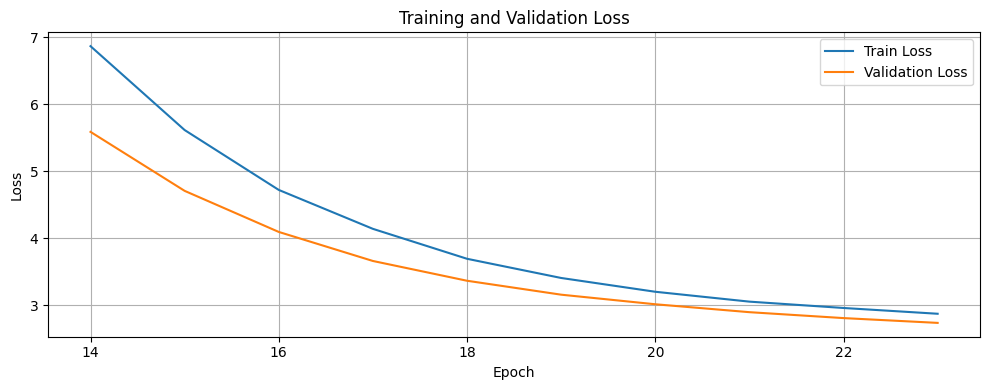

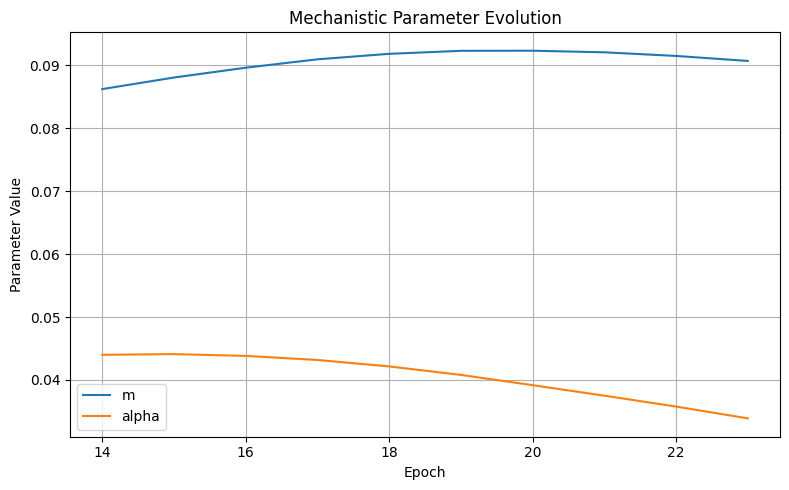

📁 Best model saved at: checkpoints\best_model.pt
📊 Logs at: checkpoints\training_log.csv


In [10]:
# --------------------------------------------------------------------
# Visualization (Loss and Parameters)
# --------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(log_path)
df = df.dropna(subset=["train_loss", "val_loss"])

plt.figure(figsize=(10,4))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
plt.plot(df["epoch"], df["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(os.path.join(log_dir, "loss_curve.png"))
plt.show()

plt.figure(figsize=(8,5))
for p in ["theta", "m", "alpha"]:
    if p in df.columns:
        plt.plot(df["epoch"], df[p], label=p)
plt.xlabel("Epoch")
plt.ylabel("Parameter Value")
plt.title("Mechanistic Parameter Evolution")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(os.path.join(log_dir, "parameter_evolution.png"))
plt.show()

# print(f"\n✅ Training complete. Best val_loss = {best_val_loss:.6f}")
print(f"📁 Best model saved at: {best_model_path}")
print(f"📊 Logs at: {log_path}")

In [11]:
# --------------------------------------------------------------------
# TEST LOOP
# --------------------------------------------------------------------
# Load best model
checkpoint = torch.load(best_model_path, map_location=device, weights_only=True)
fx.load_state_dict(checkpoint['model_state_dict'])
fx.eval()

total_test_loss = 0.0
n_test_batches = 0

with torch.no_grad():
    for batch in test_loader:
        X = batch['X'].to(device)
        P = batch['P'].to(device)
        mask = batch['mask'].to(device)
        B, T, _ = X.shape
        P0 = P[:, 0:1, :].contiguous()
        data = {'xn': P0, 'un': X}
        outputs = dynamics_model(data)
        P_pred = outputs['xn'][:, :T, :]

        mask_sum = mask.sum()
        if mask_sum == 0:
            continue
        test_loss = torch.sum(mask.unsqueeze(-1) * (P_pred - P) ** 2) / (mask_sum + 1e-8)
        total_test_loss += test_loss.item()
        n_test_batches += 1

avg_test_loss = total_test_loss / max(1, n_test_batches)
print(f"\n🧪 Test Loss: {avg_test_loss:.6f}")


🧪 Test Loss: 2.853797


### Compare observed and predicted trajectories

In [13]:
# Load the checkpoint
checkpoint = torch.load("checkpoints/best_model.pt", map_location=device, weights_only=True)

# Extract the best parameters
best_params = checkpoint.get('params', {})
m_best = best_params.get('m', None)
alpha_best = best_params.get('alpha', None)

print("📌 Best Parameters:")
print(f"  m:     {m_best}")
print(f"  alpha: {alpha_best}")

📌 Best Parameters:
  m:     0.09068604558706284
  alpha: 0.03389925882220268


In [14]:
# --- Load trained model from checkpoint ---
fx = HybridRHS(n_inputs=3, n_hidden=64, n_outputs=1).to(device)

checkpoint = torch.load("checkpoints/best_model.pt", map_location=device, weights_only=True)
fx.load_state_dict(checkpoint['model_state_dict'])
fx.eval() 

# Neural network correction
nn_correction = fx.nn

# Theta network
theta_net = fx.theta_net

# Mechanistic parameters
m_value = fx.m.item()
alpha_value = fx.alpha.item()

print(nn_correction)
print(theta_net)
print(f"m = {m_value}, alpha = {alpha_value}")

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=1, bias=True)
  (3): Softplus(beta=1.0, threshold=20.0)
)
m = 0.09068604558706284, alpha = 0.03389925882220268


In [34]:
norm_df = norm_df.reset_index().set_index(['month_year','lat','lon'])
norm_df = norm_df.sort_index()
print(norm_df.index.names)
# Sort by time
df = norm_df.sort_index(level='month_year')
print(df.index.names)

['month_year', 'lat', 'lon']
['month_year', 'lat', 'lon']


In [40]:
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.interpolate import interp1d
from dateutil.relativedelta import relativedelta

# Get unique grid locations
locations = df.index.droplevel('month_year').unique()

# ----------------------------
# Helper functions
# ----------------------------
def months_since_start(dates):
    """Convert datetime-like array to months since first date."""
    dates = pd.to_datetime(dates)
    return np.array([(d.year - dates[0].year) * 12 + (d.month - dates[0].month) for d in dates], dtype=np.float32)

def make_forcing_function(df_cell_agg, forcing_cols=['rsn', 'Tf','V']):
    """Create interpolating forcing function for a single cell."""
    # Convert time to numeric
    t = months_since_start(df_cell_agg.index.get_level_values('month_year'))
    
    u_data = df_cell_agg[forcing_cols].values.astype(np.float32)
    
    # Remove duplicates in time (interp1d requires strictly increasing)
    t, unique_idx = np.unique(t, return_index=True)
    u_data = u_data[unique_idx, :]
    
    u_interp = [interp1d(t, u_data[:, i], kind='linear', fill_value='extrapolate') 
                for i in range(u_data.shape[1])]
    def forcing_func(t_query):
        return np.stack([f(t_query) for f in u_interp], axis=-1)
    
    return forcing_func, t


def integrate_cell(df_cell_agg, fx, P0_col='logmcro'):
    """
    Integrate one cell given UDE model fx and aggregated cell dataframe.
    Returns (time_vector, P_pred_vector)
    """
    forcing_func, t_vals = make_forcing_function(df_cell_agg)
    
    fx.eval()
    
    # Initial condition
    P0 = df_cell_agg[P0_col].iloc[0]
    
    # Integrate using RK4 or any integrator you have
    # Here we assume you have fxRK4/Node/System like before
    data = {
        'xn': torch.tensor([[P0]], dtype=torch.float32).cpu(),
        'un': torch.tensor(forcing_func(t_vals), dtype=torch.float32).unsqueeze(0).cpu()
    }
    
    outputs = dynamics_model(data)  # returns dict with 'xn'
    P_pred = outputs['xn'].squeeze().detach().cpu().numpy()
    
    return t_vals, P_pred

def process_cell(lon, lat, fx, df):
    """Process one (lon, lat) cell: aggregate, integrate, return trajectory."""
    try:
        lon = float(lon)
        lat = float(lat)
        df_cell = df.loc[(lon, lat)]
        if df_cell.empty:
           raise ValueError("Empty cell")
        # Aggregate duplicates by month_year
        df_cell_agg = df_cell.groupby(level='month_year').mean()
        if 'logmcro' not in df_cell_agg.columns:
            raise ValueError("Missing logmcro")
        t, P_pred = integrate_cell(df_cell_agg, fx)
        obs = df_cell_agg['logmcro'].values
        return (lon, lat), pd.DataFrame({'time': t, 'P_pred': P_pred, 'obs': obs})
    except Exception as e:
        print(f"⚠️ Error at ({lon},{lat}): {e}")
        return (lon, lat), None

In [48]:
# ----------------------------
# Parallel integration
# ----------------------------
import random
test_locations = random.sample(list(locations), 10)

fx.to('cpu')  # move model to CPU for parallelization
dynamics_model.to('cpu')
print("fx device:", next(fx.parameters()).device)

# Run in parallel
results = Parallel(n_jobs=-1)(
    delayed(process_cell)(lon, lat, fx, df) for lon, lat in tqdm(test_locations)
)

# Filter out failed cells
results_dict = {loc: traj for loc, traj in results if traj is not None}

fx device: cpu


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 6511.88it/s]


In [49]:
for loc, df_traj in results_dict.items():
    print(f"\n📍 Location: {loc}")
    print(df_traj.head())

In [ ]:
# Pick a few locations to visualize
sample_locs = list(trajectories.keys())[:5]

for loc in sample_locs:
    traj = trajectories[loc]
    plt.figure(figsize=(8, 4))
    plt.plot(traj['time'], traj['obs'], label='Observed', marker='o')
    plt.plot(traj['time'], traj['P_pred'], label='Predicted', marker='x')
    plt.title(f'Location: {loc}')
    plt.xlabel('Months since start')
    plt.ylabel('logmcro')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
# ----------------------------
# Compute mean trajectory across all cells
# ----------------------------

all_obs = []
all_pred = []
all_time = None

for df_cell in trajectories.values():
    all_obs.append(df_cell['obs'].values)
    all_pred.append(df_cell['P_pred'].values)
    if all_time is None:
        all_time = df_cell['time'].values

all_obs_mat = np.vstack(all_obs)
all_pred_mat = np.vstack(all_pred)

mean_obs = np.nanmean(all_obs_mat, axis=0)
mean_pred = np.nanmean(all_pred_mat, axis=0)

ValueError: need at least one array to concatenate

In [38]:
# ----------------------------
# Plot mean trajectories
# ----------------------------

plt.figure(figsize=(8,5))
plt.plot(all_time, mean_obs, 'o-', label='Observed logmcro')
plt.plot(all_time, mean_pred, 's--', label='Predicted P_pred')
plt.xlabel('Months since start')
plt.ylabel('logmcro / Chl-a')
plt.title('Mean trajectories across all grid cells')
plt.legend()
plt.show()

Grid (-179.5,-76.5) correlation: -0.3276395299833865
Grid (-179.5,-75.5) correlation: -0.2842183756265454
Grid (-179.5,-68.5) correlation: 0.11866415914760557
Grid (-179.5,-66.5) correlation: 0.597509934317538
Grid (-179.5,-63.5) correlation: 0.027722304424402426
Grid (-179.5,-62.5) correlation: -0.21581822608898277
Grid (-179.5,-61.5) correlation: -0.10121181470255226
Grid (-179.5,-60.5) correlation: -0.27963379969117574
Grid (-179.5,-59.5) correlation: -0.2484726486782538
Grid (-179.5,-58.5) correlation: -0.2689601545107828
Grid (-179.5,-57.5) correlation: -0.23480172248971773
Grid (-179.5,-56.5) correlation: -0.28363817575475686
Grid (-179.5,-55.5) correlation: 0.0358486722684028
Grid (-179.5,-54.5) correlation: 0.06319528294252465
Grid (-179.5,-53.5) correlation: -0.23239907827706713
Grid (-179.5,-52.5) correlation: 0.026980341299118138
Grid (-179.5,-51.5) correlation: -0.07281388395859761
Grid (-179.5,-50.5) correlation: -0.09410323901484616
Grid (-179.5,-49.5) correlation: -0.182

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (-39.5,-0.5) correlation: -0.1252642877842618
Grid (-39.5,0.5) correlation: -0.11071113116468022
Grid (-39.5,3.5) correlation: -0.17130247102167426
Grid (-39.5,5.5) correlation: 0.09106816570228986
Grid (-39.5,8.5) correlation: -0.6065858384805517
Grid (-39.5,9.5) correlation: -0.491987774609272
Grid (-39.5,10.5) correlation: -0.33903491779667105
Grid (-39.5,12.5) correlation: -0.3385477219256306
Grid (-39.5,14.5) correlation: -0.43721993752251304
Grid (-39.5,15.5) correlation: -0.19515657491719987
Grid (-39.5,16.5) correlation: 0.087550696474485
Grid (-39.5,17.5) correlation: -0.25994367582453204
Grid (-39.5,21.5) correlation: -0.4328617708165633
Grid (-39.5,22.5) correlation: -0.6724202959274578
Grid (-39.5,24.5) correlation: -0.1544235047326519
Grid (-39.5,27.5) correlation: -0.45356881314467096
Grid (-39.5,28.5) correlation: -0.21129173957605335
Grid (-39.5,31.5) correlation: -0.06240790425732551
Grid (-39.5,32.5) correlation: -0.12757177924153817
Grid (-39.5,33.5) correlation

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (-159.5,24.5) correlation: -0.5237179448913196
Grid (-159.5,25.5) correlation: -0.5968309321383277
Grid (-159.5,27.5) correlation: -0.45907407247105125
Grid (-159.5,29.5) correlation: 0.11594496786374721
Grid (-159.5,30.5) correlation: 0.45066897630758196
Grid (-159.5,45.5) correlation: -0.04790733494729201
Grid (-159.5,48.5) correlation: -0.09373394038124369
Grid (-159.5,49.5) correlation: 0.011618800236373808
Grid (-159.5,50.5) correlation: 0.16461072527406626
Grid (-159.5,53.5) correlation: -0.06163717646727206
Grid (-159.5,54.5) correlation: -0.08818476547134928
Grid (-159.5,57.5) correlation: -0.1048137952780479
Grid (-159.5,58.5) correlation: -0.17663733434980314
Grid (-158.5,-68.5) correlation: -0.5730815408515231
Grid (-158.5,-63.5) correlation: -0.022953971876161952
Grid (-158.5,-55.5) correlation: -0.17968629664295666
Grid (-158.5,-51.5) correlation: 0.008278004464637344
Grid (-158.5,-6.5) correlation: -0.33558737929501414
Grid (-158.5,-4.5) correlation: -0.3017006687069

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (-74.5,-68.5) correlation: -0.5976596358723102
Grid (-74.5,-67.5) correlation: 0.3066458136583279
Grid (-74.5,-61.5) correlation: -0.2799931274014495
Grid (-74.5,-29.5) correlation: 0.1165768304090672
Grid (-74.5,-28.5) correlation: -0.08477054565718603
Grid (-74.5,-25.5) correlation: 0.07332968237527256
Grid (-74.5,-20.5) correlation: -0.34437566766033734
Grid (-74.5,16.5) correlation: -0.1012419194936593
Grid (-73.5,-68.5) correlation: -0.7066602613223443
Grid (-73.5,-56.5) correlation: -0.14602694170128455
Grid (-73.5,-29.5) correlation: -0.14250040491915528
Grid (-73.5,16.5) correlation: -0.05212611208882674
Grid (-73.5,21.5) correlation: 0.054762301347200275
Grid (-73.5,22.5) correlation: -0.6624859304146653
Grid (-73.5,23.5) correlation: -0.5181497676682948
Grid (-73.5,24.5) correlation: -0.2278296383696615
Grid (-73.5,33.5) correlation: -0.6876766818213724
Grid (-73.5,35.5) correlation: -0.7707942573219376
Grid (-72.5,-68.5) correlation: -0.8094834458775325
Grid (-72.5,-60.

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (157.5,-24.5) correlation: 0.042122283191001295
Grid (157.5,-21.5) correlation: -0.1321932125156358
Grid (157.5,-6.5) correlation: 0.044228068713455256
Grid (157.5,-3.5) correlation: 0.1289834319328041
Grid (157.5,-2.5) correlation: -0.13519015211961843
Grid (157.5,3.5) correlation: 0.09411677892780737
Grid (157.5,4.5) correlation: 0.34491586716138
Grid (157.5,8.5) correlation: -0.19835841200889537
Grid (157.5,21.5) correlation: 0.19579647128479574
Grid (157.5,29.5) correlation: -0.18051683470805316
Grid (157.5,31.5) correlation: 0.06730762886459805
Grid (157.5,32.5) correlation: 0.14278184537066455
Grid (157.5,34.5) correlation: -0.05123953333557659
Grid (157.5,35.5) correlation: -0.08294936114025651
Grid (157.5,36.5) correlation: 0.010713546888234093
Grid (157.5,37.5) correlation: -0.07304235483869659
Grid (157.5,49.5) correlation: -0.09055304069128293
Grid (158.5,-65.5) correlation: 0.21525074603518207
Grid (158.5,-31.5) correlation: -0.31742874647060276
Grid (158.5,-27.5) corr

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (-164.5,8.5) correlation: -0.2107254707679751
Grid (-164.5,37.5) correlation: -0.08618139546176676
Grid (-164.5,51.5) correlation: 0.2089373897108223
Grid (-164.5,59.5) correlation: -0.32080202896877047
Grid (-163.5,7.5) correlation: -0.3333217547506346
Grid (-163.5,11.5) correlation: 0.6630729132301288
Grid (-163.5,46.5) correlation: -0.1292051116994558
Grid (-163.5,47.5) correlation: -0.20624968095337065
Grid (-163.5,49.5) correlation: 0.11174530328614381
Grid (-162.5,-25.5) correlation: -0.19220768179384803
Grid (-162.5,16.5) correlation: 0.024547220659280368
Grid (-162.5,24.5) correlation: -0.13392330128821142
Grid (-162.5,59.5) correlation: 0.22906515713399356
Grid (-161.5,-54.5) correlation: -0.18912139321851767
Grid (-161.5,12.5) correlation: 0.5082573032350843
Grid (-161.5,24.5) correlation: -0.02183324223618712
Grid (-161.5,47.5) correlation: 0.019591221877029146
Grid (-161.5,49.5) correlation: 0.08038932767957767
Grid (-160.5,-26.5) correlation: 0.12304781425732757
Grid 

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (-61.5,17.5) correlation: 0.11201242118280255
Grid (-61.5,37.5) correlation: -0.570449737264433
Grid (-61.5,40.5) correlation: -0.6758212524703266
Grid (-61.5,41.5) correlation: -0.5436214534141893
Grid (-61.5,42.5) correlation: -0.3493409447674869
Grid (-60.5,-60.5) correlation: 0.09457777352049725
Grid (-60.5,16.5) correlation: 0.07456230890035713
Grid (-60.5,38.5) correlation: -0.7211104945996825
Grid (-60.5,40.5) correlation: -0.7241906217932852
Grid (-60.5,41.5) correlation: -0.6480474802631523
Grid (-60.5,42.5) correlation: -0.44373474136875474
Grid (-60.5,43.5) correlation: -0.1704417413570311
Grid (-59.5,14.5) correlation: 0.10213839453037783
Grid (-59.5,15.5) correlation: 0.062304397032073376
Grid (-59.5,16.5) correlation: 0.1799130005450736
Grid (-59.5,28.5) correlation: -0.04334331092750683
Grid (-59.5,38.5) correlation: -0.6636325180292612
Grid (-59.5,39.5) correlation: -0.6525697399920961
Grid (-59.5,42.5) correlation: -0.340174296797571
Grid (-59.5,43.5) correlation:

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (173.5,28.5) correlation: -0.41418115957970075
Grid (173.5,49.5) correlation: 0.06547566951769901
Grid (173.5,54.5) correlation: -0.0031534806561552553
Grid (173.5,55.5) correlation: -0.1045030421066527
Grid (173.5,57.5) correlation: 0.11163503127428866
Grid (173.5,58.5) correlation: -0.09381608974487918
Grid (174.5,-65.5) correlation: 0.2797649599146338
Grid (174.5,-27.5) correlation: -0.2506459176790582
Grid (174.5,-19.5) correlation: 0.03714512016747232
Grid (174.5,-14.5) correlation: 0.38130883303484775
Grid (174.5,-9.5) correlation: 0.7002776643420576
Grid (174.5,-8.5) correlation: 0.6462789234707479
Grid (174.5,-7.5) correlation: 0.513199687917576
Grid (174.5,37.5) correlation: 0.08452555827490255
Grid (174.5,46.5) correlation: -0.2577658454991394
Grid (174.5,49.5) correlation: -0.09633458244350077
Grid (174.5,51.5) correlation: -0.09982496952075344
Grid (174.5,53.5) correlation: -0.11338748374136633
Grid (174.5,54.5) correlation: -0.037983007548435914
Grid (174.5,55.5) corr

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (178.5,53.5) correlation: 0.0781871099783678
Grid (178.5,55.5) correlation: 0.07004477549984188
Grid (178.5,60.5) correlation: -0.04753714798224329
Grid (179.5,20.5) correlation: 0.5701817545259426
Grid (179.5,55.5) correlation: -0.08588876016672868
Grid (179.5,58.5) correlation: 0.18869799175507562
Grid (179.5,60.5) correlation: -0.007457467497127074
Grid (-179.5,-12.5) correlation: -0.39166776436287015
Grid (-179.5,7.5) correlation: -0.005930044222477915
Grid (-179.5,9.5) correlation: 0.2135786355893731
Grid (-179.5,55.5) correlation: 0.29665374122262445
Grid (-179.5,62.5) correlation: 0.028207573349733242
Grid (-179.5,63.5) correlation: 0.1299600636859184
Grid (-178.5,8.5) correlation: -0.09754626318353718
Grid (-178.5,55.5) correlation: 0.24720058792000257
Grid (-178.5,59.5) correlation: 0.2416345612420724
Grid (-178.5,63.5) correlation: 0.21591193988149737
Grid (-177.5,-30.5) correlation: 0.11157496242932956
Grid (-177.5,-18.5) correlation: 0.25269404835627207
Grid (-177.5,46

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (-161.5,-31.5) correlation: 0.016156481716495873
Grid (-161.5,-30.5) correlation: -0.10222289559205465
Grid (-161.5,-24.5) correlation: -0.5788102184421211
Grid (-161.5,-23.5) correlation: -1.0
Grid (-161.5,-10.5) correlation: -0.13394587114664833
Grid (-161.5,-9.5) correlation: -0.08589211585901957
Grid (-161.5,10.5) correlation: -0.1675043801358138
Grid (-161.5,18.5) correlation: 0.47772292133305994
Grid (-161.5,70.5) correlation: -0.367084814337314
Grid (-160.5,-32.5) correlation: 0.1575773758936929
Grid (-160.5,-31.5) correlation: -0.045944427747792595
Grid (-160.5,-29.5) correlation: 0.1480809576749131
Grid (-160.5,-28.5) correlation: -0.33165973536903476
Grid (-160.5,-24.5) correlation: -0.7484101546821047
Grid (-160.5,15.5) correlation: 0.9436508302711963
Grid (-159.5,-35.5) correlation: -0.0035510326209032207
Grid (-159.5,-31.5) correlation: 0.029479691969411206
Grid (-159.5,-21.5) correlation: nan
Grid (-158.5,-33.5) correlation: 0.10290385042925136
Grid (-158.5,-26.5) co

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (-55.5,24.5) correlation: -0.9502472965064012
Grid (-55.5,54.5) correlation: -0.022408533533927202
Grid (-55.5,65.5) correlation: -0.4817008742095643
Grid (-55.5,68.5) correlation: -0.19287026339865254
Grid (-55.5,69.5) correlation: -0.3688330813996275
Grid (-55.5,70.5) correlation: -0.3067241218459837
Grid (-54.5,17.5) correlation: 0.17192586665828133
Grid (-53.5,18.5) correlation: 0.7070175136368051
Grid (-53.5,22.5) correlation: -0.530500697979118
Grid (-53.5,68.5) correlation: 0.16348046042146597
Grid (-53.5,71.5) correlation: -0.07058324239662749
Grid (-52.5,60.5) correlation: -0.2438285221035817
Grid (-51.5,14.5) correlation: -0.14000199216122394
Grid (-50.5,14.5) correlation: -0.05544886065192601
Grid (-48.5,0.5) correlation: -0.17390973341563157
Grid (-48.5,17.5) correlation: -0.11697681371278125
Grid (-45.5,4.5) correlation: -0.026010205469316476
Grid (-41.5,6.5) correlation: -0.3367772817462318
Grid (-41.5,62.5) correlation: -0.020883472386081122
Grid (-40.5,3.5) correla

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Grid (-15.5,-18.5) correlation: -0.5456416372728718
Grid (-15.5,-17.5) correlation: -0.33899436387294557
Grid (-15.5,-14.5) correlation: 0.11262148732037706
Grid (-15.5,-9.5) correlation: 0.01307495071768364
Grid (-14.5,-19.5) correlation: -0.6078751590217356
Grid (-14.5,-17.5) correlation: -0.6293351183073149
Grid (-14.5,-15.5) correlation: 0.2502758339064055
Grid (-14.5,4.5) correlation: 0.10978656040027898
Grid (-13.5,-32.5) correlation: -0.16290129461324268
Grid (-13.5,-19.5) correlation: -0.4571438645481572
Grid (-13.5,-18.5) correlation: -0.5942060897133177
Grid (-13.5,-16.5) correlation: -0.1412724352445747
Grid (-13.5,-15.5) correlation: -0.03798535690613399
Grid (-13.5,-12.5) correlation: -0.23849900878655214
Grid (-13.5,74.5) correlation: -0.0964687650464418
Grid (-12.5,-32.5) correlation: -0.21518652109693434
Grid (-12.5,-28.5) correlation: -0.2801405484980313
Grid (-12.5,-20.5) correlation: -0.4850112971259356
Grid (-12.5,-19.5) correlation: 0.10216969494999611
Grid (-12.5,

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (-146.5,-28.5) correlation: -0.404352307931779
Grid (-146.5,-19.5) correlation: -0.03875651178026865
Grid (-146.5,15.5) correlation: 0.34849762395924155
Grid (-146.5,71.5) correlation: 0.00935263932704297
Grid (-146.5,73.5) correlation: -0.8437384901399858
Grid (-145.5,-33.5) correlation: 0.2738266665170948
Grid (-145.5,-28.5) correlation: -0.6148978671179173
Grid (-145.5,23.5) correlation: 0.6449921838129536
Grid (-145.5,70.5) correlation: -0.0676896439957698
Grid (-144.5,-29.5) correlation: 0.21613399081813447
Grid (-144.5,-28.5) correlation: -0.01919197701290088
Grid (-144.5,-16.5) correlation: -0.3873259737787378
Grid (-144.5,-15.5) correlation: -0.6213820855538925
Grid (-144.5,16.5) correlation: -0.20511920488889215
Grid (-144.5,73.5) correlation: -0.48550741872668673
Grid (-143.5,-33.5) correlation: 0.44351921116262755
Grid (-143.5,-29.5) correlation: 0.1552598565900862
Grid (-143.5,-28.5) correlation: -0.33193111859293095
Grid (-142.5,-33.5) correlation: 0.32710205243624507

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (-24.5,70.5) correlation: 0.4387314763019617
Grid (-23.5,-21.5) correlation: 0.021821632036646017
Grid (-23.5,-19.5) correlation: nan
Grid (-23.5,-16.5) correlation: -0.9593350712879651
Grid (-23.5,-15.5) correlation: -0.13307123517800015
Grid (-23.5,-11.5) correlation: -0.1815496923761315
Grid (-22.5,-27.5) correlation: -0.008748915457176144
Grid (-22.5,-18.5) correlation: 0.09312052068596029
Grid (-22.5,-16.5) correlation: -0.28943103383078694
Grid (-22.5,-13.5) correlation: 0.03457763566598165
Grid (-22.5,-12.5) correlation: 0.17980136827107052
Grid (-22.5,-9.5) correlation: 0.18778675795843094
Grid (-22.5,-8.5) correlation: -0.02096804268218575
Grid (-22.5,69.5) correlation: 0.16102193779365942
Grid (-21.5,-19.5) correlation: -0.48117777666347245
Grid (-21.5,-18.5) correlation: 0.36302877901512826
Grid (-21.5,-16.5) correlation: -0.26164557872716276
Grid (-21.5,-14.5) correlation: -0.15916636878014573
Grid (-21.5,-12.5) correlation: -0.1078035458948053
Grid (-21.5,-11.5) corre

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (126.5,80.5) correlation: nan
Grid (127.5,12.5) correlation: 0.26919122333069456
Grid (127.5,74.5) correlation: 0.01101670385582052
Grid (127.5,78.5) correlation: 0.3592421849014844
Grid (127.5,79.5) correlation: 0.8745871491262619
Grid (127.5,80.5) correlation: nan
Grid (128.5,78.5) correlation: 0.14262185597999083
Grid (128.5,79.5) correlation: 0.99970482057163
Grid (128.5,80.5) correlation: nan
Grid (129.5,71.5) correlation: -0.10042564947143019
Grid (129.5,79.5) correlation: 0.49289279990719903
Grid (130.5,-52.5) correlation: -0.12897873110017866
Grid (130.5,6.5) correlation: 0.18147652517579704
Grid (130.5,15.5) correlation: 0.12248613246185364
Grid (130.5,16.5) correlation: -0.079476975269802
Grid (130.5,73.5) correlation: 0.3984878287661954
Grid (130.5,79.5) correlation: 0.47270328074956025
Grid (131.5,71.5) correlation: 0.34156088511401955
Grid (131.5,72.5) correlation: -0.04542900554532839
Grid (131.5,73.5) correlation: 0.2740172106130439
Grid (131.5,79.5) correlation: 0.

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (-128.5,-21.5) correlation: nan
Grid (-127.5,-32.5) correlation: -0.04279083047913044
Grid (-125.5,-55.5) correlation: 0.08076154454933239
Grid (-125.5,-32.5) correlation: 0.10880884931794028
Grid (-125.5,-20.5) correlation: -0.6636671035898177
Grid (-124.5,-37.5) correlation: -0.006713512735484372
Grid (-124.5,-31.5) correlation: 0.024775715559719885
Grid (-124.5,-22.5) correlation: -1.0
Grid (-123.5,-31.5) correlation: -0.1598993310631451
Grid (-123.5,-23.5) correlation: nan
Grid (-123.5,-22.5) correlation: -0.10846857725676301
Grid (-123.5,27.5) correlation: 0.05768243867016695
Grid (-122.5,-31.5) correlation: -0.4657608264116788
Grid (-122.5,-22.5) correlation: nan
Grid (-121.5,-30.5) correlation: 0.006773146271811475
Grid (-121.5,-23.5) correlation: nan
Grid (-121.5,-20.5) correlation: -0.469095984399142
Grid (-120.5,-23.5) correlation: nan
Grid (-120.5,-22.5) correlation: 1.0
Grid (-120.5,-19.5) correlation: -0.03193895933856633
Grid (-119.5,-47.5) correlation: -0.2923129129

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (-147.5,17.5) correlation: 0.19333523914018572
Grid (-147.5,18.5) correlation: -0.08731179915422563
Grid (-145.5,-15.5) correlation: 0.09229931413203815
Grid (-145.5,19.5) correlation: -0.15608112011807046
Grid (-144.5,15.5) correlation: 0.1934348582016099
Grid (-144.5,24.5) correlation: 0.022085700779347916
Grid (-143.5,-61.5) correlation: 0.22590833211778824
Grid (-140.5,17.5) correlation: 0.34876659322545966
Grid (-139.5,-74.5) correlation: -0.7002319953885092
Grid (-139.5,25.5) correlation: 0.39825773090059396
Grid (-138.5,-66.5) correlation: 0.3887511157569076
Grid (-138.5,-18.5) correlation: -0.29121686521050977
Grid (-138.5,22.5) correlation: -0.43828032370471387
Grid (-138.5,30.5) correlation: -0.1157700101657857
Grid (-136.5,-65.5) correlation: 0.10661503536259216
Grid (-136.5,24.5) correlation: 0.018174940497367217
Grid (-135.5,26.5) correlation: 0.06493198542612376
Grid (-135.5,28.5) correlation: -0.06397167902424006
Grid (-133.5,-59.5) correlation: -0.04554982474003899

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (78.5,-62.5) correlation: -0.2470519553274858
Grid (81.5,-58.5) correlation: 0.18059825008642547
Grid (84.5,-52.5) correlation: -0.06690061851530153
Grid (86.5,-58.5) correlation: -0.24100548251484274
Grid (86.5,-57.5) correlation: -0.06236870772541694
Grid (87.5,-60.5) correlation: -0.0007293834846979303
Grid (88.5,-57.5) correlation: 0.16137195821696979
Grid (88.5,-55.5) correlation: -0.24788802851099115
Grid (93.5,-65.5) correlation: 0.2669278598655811
Grid (100.5,-61.5) correlation: -0.04595414267367485
Grid (106.5,-61.5) correlation: 0.3966089523248418
Grid (106.5,-57.5) correlation: 0.495706031499645
Grid (107.5,-58.5) correlation: 0.4014787473820458
Grid (108.5,-57.5) correlation: 0.5869056489929204
Grid (109.5,-60.5) correlation: 0.1013944959151024
Grid (110.5,-62.5) correlation: 0.011045574228574707
Grid (111.5,-57.5) correlation: 0.5109414061568351
Grid (112.5,-61.5) correlation: 0.013393640689681756
Grid (112.5,-57.5) correlation: 0.3855255706439027
Grid (115.5,-54.5) c

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (-32.5,-68.5) correlation: 0.3337772600991941
Grid (-31.5,-68.5) correlation: 0.7756439535559015
Grid (-31.5,-14.5) correlation: 1.0
Grid (-30.5,-67.5) correlation: 0.45548632719295573
Grid (-29.5,-66.5) correlation: 0.5181185124396005
Grid (-29.5,-62.5) correlation: 0.20013997404394862
Grid (-28.5,-69.5) correlation: 0.17758557875592604
Grid (-26.5,-69.5) correlation: 0.11550141472752581
Grid (-26.5,-68.5) correlation: 0.5924167989874056
Grid (-26.5,-67.5) correlation: -0.2000051237459166
Grid (-26.5,-64.5) correlation: 0.6619103270628562
Grid (-26.5,-60.5) correlation: 0.7247196126816251
Grid (-26.5,-59.5) correlation: 0.4100152343145539
Grid (-25.5,-69.5) correlation: 0.1229304382635225
Grid (-25.5,-67.5) correlation: 0.3801829711546364
Grid (-25.5,-63.5) correlation: -0.3004660640822233
Grid (-25.5,-60.5) correlation: 0.34757583539740006
Grid (-24.5,-70.5) correlation: 0.7160775340972911
Grid (-24.5,-61.5) correlation: -0.707546104422698
Grid (-23.5,-65.5) correlation: 0.52028

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (-146.5,72.5) correlation: -0.1332345892204818
Grid (-146.5,74.5) correlation: -0.301939458327841
Grid (-145.5,72.5) correlation: 0.13124233587160083
Grid (-145.5,73.5) correlation: -0.1781088755769083
Grid (-145.5,74.5) correlation: -0.8003401205763827
Grid (-144.5,-23.5) correlation: 0.2217358169477012
Grid (-144.5,72.5) correlation: -0.09202731283319346
Grid (-143.5,72.5) correlation: -0.16722497512065262
Grid (-143.5,73.5) correlation: 0.005054799333376572
Grid (-141.5,71.5) correlation: -0.32297381007801573
Grid (-141.5,72.5) correlation: 0.05035518746658711
Grid (-141.5,73.5) correlation: -0.34804238972256535
Grid (-140.5,73.5) correlation: 0.04379918392808122
Grid (-139.5,-23.5) correlation: 1.0
Grid (-139.5,72.5) correlation: 0.062069436266324544
Grid (-138.5,71.5) correlation: 0.03489592387085256
Grid (-138.5,72.5) correlation: 0.22960844033900285
Grid (-137.5,72.5) correlation: -0.3130232955501634
Grid (-132.5,72.5) correlation: 0.33650918531429286
Grid (-131.5,-30.5) co

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (153.5,78.5) correlation: 0.37078913612323877
Grid (154.5,76.5) correlation: 0.2914503437252981
Grid (154.5,77.5) correlation: 0.0825159821704796
Grid (155.5,76.5) correlation: 0.037176251666357
Grid (155.5,77.5) correlation: 0.33933204298382025
Grid (156.5,76.5) correlation: -0.13001920431180172
Grid (156.5,77.5) correlation: 0.7338641104157323
Grid (156.5,78.5) correlation: 0.3341243658022003
Grid (157.5,20.5) correlation: 0.3859444693550898
Grid (157.5,76.5) correlation: -0.24107415281477443
Grid (157.5,77.5) correlation: 0.9236808030795332
Grid (158.5,75.5) correlation: -0.2590998224480748
Grid (158.5,76.5) correlation: -0.3889658109690396
Grid (158.5,77.5) correlation: 0.6150339602750953
Grid (158.5,78.5) correlation: 0.18854304875158476
Grid (159.5,76.5) correlation: -0.5963615800092522
Grid (159.5,77.5) correlation: 0.39214650620633534
Grid (159.5,78.5) correlation: 0.8624824631912188
Grid (160.5,75.5) correlation: -0.8275269204798268
Grid (160.5,76.5) correlation: -0.71260

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (-159.5,-74.5) correlation: 0.7678369208657364
Grid (-158.5,-74.5) correlation: 0.6923672283701534
Grid (-156.5,-74.5) correlation: 0.11961516702847953
Grid (-152.5,-75.5) correlation: -0.5466878269426125
Grid (-152.5,-74.5) correlation: 0.053023852841495536
Grid (-152.5,-15.5) correlation: -0.6889119404373429
Grid (-151.5,-68.5) correlation: 0.8761443724783062
Grid (-151.5,-19.5) correlation: 0.027448524514062496
Grid (-150.5,-68.5) correlation: 0.6326212901220835
Grid (-143.5,-72.5) correlation: 0.9691976494865071
Grid (-142.5,20.5) correlation: -1.0
Grid (-140.5,-70.5) correlation: 0.9256381230795373
Grid (-140.5,19.5) correlation: -0.5821045498289876
Grid (-137.5,-68.5) correlation: 0.7961240390469284
Grid (-136.5,-67.5) correlation: 0.23003964910326724
Grid (-136.5,-63.5) correlation: 0.3136873821331806
Grid (-135.5,-67.5) correlation: 0.1538695628860821
Grid (-134.5,-73.5) correlation: 1.0
Grid (-129.5,-71.5) correlation: 0.9786635782915867
Grid (-129.5,-70.5) correlation: 0

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

Grid (-138.5,-28.5) correlation: 0.7737710885467729
Grid (-129.5,-30.5) correlation: -1.0
Grid (-120.5,-21.5) correlation: -0.27557907240411283
Grid (-107.5,-24.5) correlation: 0.894821198084207
Grid (-102.5,-24.5) correlation: 0.6627987700549934
Grid (-99.5,-25.5) correlation: 0.39457941453382184
Grid (-98.5,-26.5) correlation: 0.5860003227946377
Grid (-26.5,-16.5) correlation: -0.9800677928840624
Grid (-25.5,-16.5) correlation: -0.6836231557618871
Grid (-24.5,-16.5) correlation: 0.44936439340454165
Grid (-17.5,78.5) correlation: nan
Grid (-14.5,82.5) correlation: 0.9999999999999999
Grid (-6.5,78.5) correlation: -0.6136050785940657
Grid (-5.5,78.5) correlation: -0.6551515883377177
Grid (0.5,80.5) correlation: -0.9999999999999999
Grid (85.5,-26.5) correlation: -0.19889308753424484
Grid (85.5,-25.5) correlation: -0.5110683774272008
Grid (89.5,-24.5) correlation: 0.4386019296563959
Grid (97.5,81.5) correlation: -0.5544854933493593
Grid (100.5,80.5) correlation: -0.49699024292172744
Grid 

C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\dutts\miniconda3\envs\neuromancer\lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, N

In [51]:
# ----------------------------
# Per-cell correlation
# ----------------------------

for (lon, lat), df_cell in trajectories.items():
    corr = np.corrcoef(df_cell['obs'], df_cell['P_pred'])[0,1]
    print(f"Grid ({lon},{lat}) correlation: {corr:.3f}")


# Training 1:  
[Epoch 1] Parameter Summary:
  m: 0.055131
  alpha: 0.014865
  nn.2.bias: -0.004331
  theta_net.2.bias: -0.004883
✅ Epoch 1: New best model saved (val_loss=22.062642)
Epoch 1/30: train_loss=41.883317, val_loss=22.062642
✅ Epoch 2: New best model saved (val_loss=13.553687)
Epoch 2/30: train_loss=24.475098, val_loss=13.553687
✅ Epoch 3: New best model saved (val_loss=8.775888)
Epoch 3/30: train_loss=15.881944, val_loss=8.775888
✅ Epoch 4: New best model saved (val_loss=5.850940)
Epoch 4/30: train_loss=10.235290, val_loss=5.850940

[Epoch 5] Parameter Summary:
  m: 0.075175
  alpha: 0.033529
  nn.2.bias: -0.021118
  theta_net.2.bias: -0.024044
✅ Epoch 5: New best model saved (val_loss=3.984989)
Epoch 5/30: train_loss=6.929479, val_loss=3.984989
✅ Epoch 6: New best model saved (val_loss=2.750093)
Epoch 6/30: train_loss=4.689492, val_loss=2.750093
✅ Epoch 7: New best model saved (val_loss=1.929208)
Epoch 7/30: train_loss=3.315599, val_loss=1.929208
✅ Epoch 8: New best model saved (val_loss=1.369365)
Epoch 8/30: train_loss=2.346758, val_loss=1.369365
✅ Epoch 9: New best model saved (val_loss=0.984805)
Epoch 9/30: train_loss=1.649906, val_loss=0.984805

[Epoch 10] Parameter Summary:
  m: 0.098876
  alpha: 0.054468
  nn.2.bias: -0.040122
  theta_net.2.bias: -0.046813
✅ Epoch 10: New best model saved (val_loss=0.716207)
Epoch 10/30: train_loss=1.226151, val_loss=0.716207
✅ Epoch 11: New best model saved (val_loss=0.526599)
Epoch 11/30: train_loss=0.863876, val_loss=0.526599
✅ Epoch 12: New best model saved (val_loss=0.392699)
Epoch 12/30: train_loss=0.628519, val_loss=0.392699
✅ Epoch 13: New best model saved (val_loss=0.296894)
Epoch 13/30: train_loss=0.479267, val_loss=0.296894
✅ Epoch 14: New best model saved (val_loss=0.226384)
Epoch 14/30: train_loss=0.359525, val_loss=0.226384

[Epoch 15] Parameter Summary:
  m: 0.120104
  alpha: 0.072448
  nn.2.bias: -0.053894
  theta_net.2.bias: -0.067341
✅ Epoch 15: New best model saved (val_loss=0.174681)
Epoch 15/30: train_loss=0.271959, val_loss=0.174681
✅ Epoch 16: New best model saved (val_loss=0.136823)
Epoch 16/30: train_loss=0.214546, val_loss=0.136823
✅ Epoch 17: New best model saved (val_loss=0.108312)
Epoch 17/30: train_loss=0.173460, val_loss=0.108312
✅ Epoch 18: New best model saved (val_loss=0.086760)
Epoch 18/30: train_loss=0.131234, val_loss=0.086760
✅ Epoch 19: New best model saved (val_loss=0.070418)
Epoch 19/30: train_loss=0.106789, val_loss=0.070418

[Epoch 20] Parameter Summary:
  m: 0.138477
  alpha: 0.087684
  nn.2.bias: -0.056298
  theta_net.2.bias: -0.085104
✅ Epoch 20: New best model saved (val_loss=0.057871)
Epoch 20/30: train_loss=0.089655, val_loss=0.057871
✅ Epoch 21: New best model saved (val_loss=0.048228)
Epoch 21/30: train_loss=0.070953, val_loss=0.048228
✅ Epoch 22: New best model saved (val_loss=0.040644)
Epoch 22/30: train_loss=0.059437, val_loss=0.040644
✅ Epoch 23: New best model saved (val_loss=0.034711)
Epoch 23/30: train_loss=0.051168, val_loss=0.034711
✅ Epoch 24: New best model saved (val_loss=0.030034)
Epoch 24/30: train_loss=0.041785, val_loss=0.030034

[Epoch 25] Parameter Summary:
  m: 0.154069
  alpha: 0.100547
  nn.2.bias: -0.048421
  theta_net.2.bias: -0.100249
✅ Epoch 25: New best model saved (val_loss=0.026336)
Epoch 25/30: train_loss=0.036943, val_loss=0.026336
✅ Epoch 26: New best model saved (val_loss=0.023350)
Epoch 26/30: train_loss=0.031863, val_loss=0.023350
✅ Epoch 27: New best model saved (val_loss=0.020937)
Epoch 27/30: train_loss=0.027638, val_loss=0.020937
✅ Epoch 28: New best model saved (val_loss=0.019000)
Epoch 28/30: train_loss=0.025182, val_loss=0.019000
✅ Epoch 29: New best model saved (val_loss=0.017429)
Epoch 29/30: train_loss=0.022191, val_loss=0.017429

[Epoch 30] Parameter Summary:
  m: 0.167188
  alpha: 0.111370
  nn.2.bias: -0.034665
  theta_net.2.bias: -0.113104
✅ Epoch 30: New best model saved (val_loss=0.016092)
Epoch 30/30: train_loss=0.020294, val_loss=0.016092